In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from collections import Counter

# === Load Data ===
data = pd.read_csv("final_odi_matches_with_full_weather2.csv")
data = data.fillna(method='ffill')

# === Feature Engineering ===
data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Day'] = pd.to_datetime(data['Date']).dt.day
data['Avg_Temp_Diff'] = data['Avg_Temp_C'].diff().shift(-1)
data = data.dropna(subset=['Match Winner'])  # Ensure target is clean

# === Features & Target ===
categorical_features = ['Team1 Name', 'Team2 Name', 'Match Venue (Stadium)',
                        'Match Venue (City)', 'Match Venue (Country)']
numerical_features = ['Avg_Temp_C', 'Avg_Temp_Diff', 'Month', 'Day']
X = data[categorical_features + numerical_features]
y_raw = data['Match Winner']

# === Label Encoding ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
joblib.dump(label_encoder, 'label_encoder.pkl')

# === Smart Split: Keep rare classes in train only ===
class_counts = pd.Series(y_encoded).value_counts()
rare_classes = class_counts[class_counts < 2].index.tolist()
frequent_classes = class_counts[class_counts >= 2].index.tolist()

rare_mask = np.isin(y_encoded, rare_classes)
frequent_mask = ~rare_mask

X_rare = X[rare_mask]
y_rare = y_encoded[rare_mask]

X_frequent = X[frequent_mask]
y_frequent = y_encoded[frequent_mask]

X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(
    X_frequent, y_frequent, test_size=0.2, random_state=42, stratify=y_frequent
)

X_train = pd.concat([X_train_freq, X_rare])
y_train = np.concatenate([y_train_freq, y_rare])
X_test = X_test_freq
y_test = y_test_freq

# === Class Weight Calculation for Imbalance ===
class_counts = Counter(y_train)
n_samples = len(y_train)
n_classes = len(np.unique(y_train))
class_weight_dict = {
    cls: n_samples / (n_classes * count) for cls, count in class_counts.items()
}
sample_weights = np.array([class_weight_dict[y] for y in y_train])

# === Preprocessor Definition ===
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

# === Save All Preprocessed Artifacts ===
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
pd.DataFrame(y_train, columns=['Match_Winner']).to_csv("y_train_encoded.csv", index=False)
pd.DataFrame(y_test, columns=['Match_Winner']).to_csv("y_test_encoded.csv", index=False)
np.save("sample_weights.npy", sample_weights)
joblib.dump(preprocessor, 'preprocessor.pkl')

print("✅ Cricket match preprocessing complete and ready for XGBoost training.")


✅ Cricket match preprocessing complete and ready for XGBoost training.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\rocky's pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\rocky's pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rocky's pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.


✅ XGBoost Classification Report:
              precision    recall  f1-score   support

 Afghanistan       0.56      0.45      0.50        20
     Asia XI       1.00      1.00      1.00         3
   Australia       0.80      0.70      0.75       290
  Bangladesh       0.50      0.64      0.56        36
     Bermuda       0.00      0.00      0.00         1
      Canada       0.33      0.20      0.25         5
     England       0.62      0.65      0.64       113
   Hong Kong       1.00      0.50      0.67         2
ICC World XI       1.00      1.00      1.00         1
       India       0.76      0.62      0.68       224
     Ireland       0.52      0.77      0.62        22
       Kenya       0.62      0.45      0.53        11
     Namibia       0.67      0.67      0.67         6
       Nepal       0.50      0.43      0.46         7
 Netherlands       0.45      0.56      0.50         9
 New Zealand       0.63      0.68      0.65        98
        Oman       0.67      0.40      0.50    

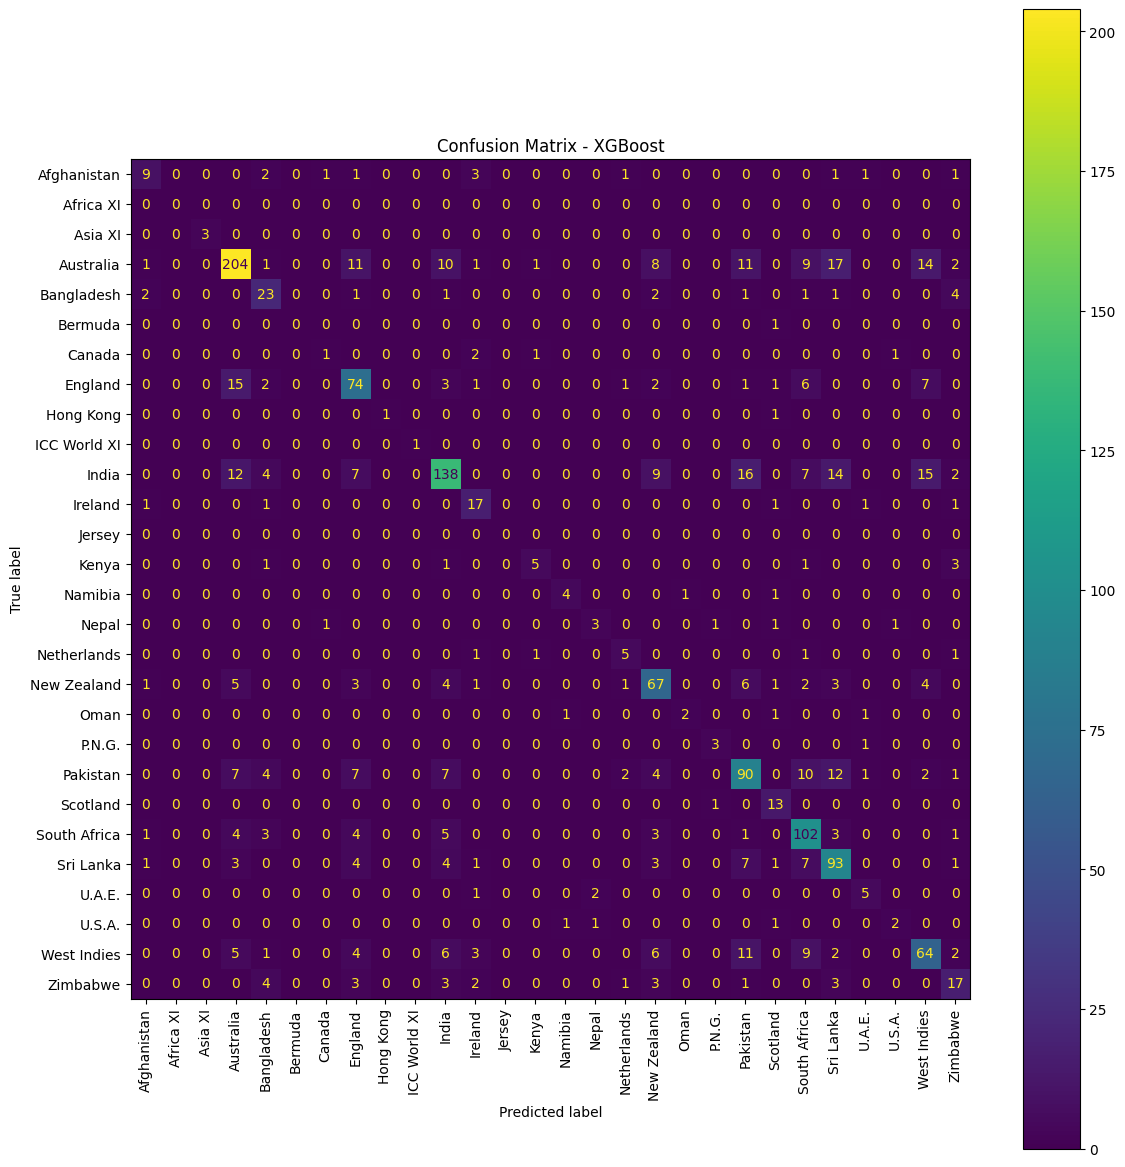

✅ Best XGBoost model saved as 'xgboost_best_model.pkl'


In [3]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Load Data ===
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train_encoded.csv")['Match_Winner'].values
y_test = pd.read_csv("y_test_encoded.csv")['Match_Winner'].values
sample_weights = np.load("sample_weights.npy")
preprocessor = joblib.load("preprocessor.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# === Define XGBoost Pipeline ===
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# === Hyperparameter Grid ===
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [4, 6, 10],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# === Hyperparameter Tuning ===
search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# === Fit Model with Sample Weights ===
search.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# === Predict and Decode Labels ===
y_pred = search.best_estimator_.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# === Evaluation ===
print("\n✅ XGBoost Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))
print("Best Hyperparameters:", search.best_params_)
print("Best CV Accuracy:", search.best_score_)

# === Confusion Matrix ===
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()

# === Save Model ===
joblib.dump(search.best_estimator_, "xgboost_best_model.pkl")
print("✅ Best XGBoost model saved as 'xgboost_best_model.pkl'")


In [4]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Load preprocessed data
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train_encoded.csv")['Match_Winner'].values
y_test = pd.read_csv("y_test_encoded.csv")['Match_Winner'].values
sample_weights = np.load("sample_weights.npy")
preprocessor = joblib.load("preprocessor.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# Define XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])

param_grid_xgb = {
    'classifier__n_estimators': [200, 300, 500],
    'classifier__max_depth': [4, 6, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
    'classifier__reg_lambda': [0.5, 1, 1.5],  # L2 regularization
    'classifier__reg_alpha': [0, 0.5, 1]       # L1 regularization
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid_xgb,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train, **{'classifier__sample_weight': sample_weights})
xgb_preds = xgb_search.best_estimator_.predict(X_test)
xgb_preds_labels = label_encoder.inverse_transform(xgb_preds)
y_test_labels = label_encoder.inverse_transform(y_test)

print("✅ Improved XGBoost Classification Report:\n")
print(classification_report(y_test_labels, xgb_preds_labels, zero_division=0))
joblib.dump(xgb_search.best_estimator_, "xgboost_improved.pkl")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\rocky's pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\rocky's pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rocky's pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.

✅ Improved XGBoost Classification Report:

              precision    recall  f1-score   support

 Afghanistan       0.50      0.45      0.47        20
     Asia XI       1.00      1.00      1.00         3
   Australia       0.81      0.77      0.79       290
  Bangladesh       0.55      0.61      0.58        36
     Bermuda       0.00      0.00      0.00         1
      Canada       0.33      0.20      0.25         5
     England       0.66      0.68      0.67       113
   Hong Kong       1.00      0.50      0.67         2
ICC World XI       1.00      1.00      1.00         1
       India       0.77      0.69      0.73       224
     Ireland       0.57      0.77      0.65        22
       Kenya       0.67      0.55      0.60        11
     Namibia       0.67      0.67      0.67         6
       Nepal       0.50      0.43      0.46         7
 Netherlands       0.44      0.44      0.44         9
 New Zealand       0.59      0.58      0.59        98
        Oman       0.67      0.40     

['xgboost_improved.pkl']

In [5]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Load preprocessed data
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train_encoded.csv")['Match_Winner'].values
y_test = pd.read_csv("y_test_encoded.csv")['Match_Winner'].values
preprocessor = joblib.load("preprocessor.pkl")

# Define Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Expanded hyperparameter grid
param_grid_rf = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [10, 20, 50, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_search.fit(X_train, y_train)
rf_preds = rf_search.best_estimator_.predict(X_test)

print("✅ Improved Random Forest Classification Report:\n")
print(classification_report(y_test, rf_preds, zero_division=0))
joblib.dump(rf_search.best_estimator_, "random_forest_improved.pkl")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\rocky's pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


✅ Improved Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.40      0.52        20
           2       1.00      1.00      1.00         3
           3       0.82      0.85      0.83       290
           4       0.55      0.67      0.60        36
           5       0.00      0.00      0.00         1
           6       0.25      0.20      0.22         5
           7       0.70      0.67      0.69       113
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       0.83      0.80      0.82       224
          11       0.57      0.77      0.65        22
          13       0.45      0.45      0.45        11
          14       0.50      0.67      0.57         6
          15       0.20      0.14      0.17         7
          16       0.25      0.11      0.15         9
          17       0.63      0.62      0.63        98
          18       0.43      0.6

['random_forest_improved.pkl']